# TP2

## Enunciado

### Problema 2


2. O Conway’s Game of Life é um exemplo bastante conhecido de um autómato celular . Neste problema vamos modificar as regras do autómato da seguinte forma

    1. O espaço de estados é finito definido por uma grelha de células booleanas (morta=0/viva=1) de dimensão $\,N\times N\,$ (com $N>3$) identificadas por índices $\,(i,j)\in \{1..N\}$.  Estas $\;N^2\;$ células são aqui referidas como “normais”. 
        No estado inicial todas as células normais estão mortas excepto  um quadrado $\,3\times 3\,$, designado por “centro”, aleatoriamente posicionado formado apenas por células vivas.
    2. Adicionalmente existem $\,2\,N+1\,$ “células da borda” que correspondem a um dos índices, $i$ ou $j$, ser zero. As células da borda têm valores constantes que, no estado inicial, são gerados aleatoriamente com uma probabilidade $\,\rho\,$ de estarem vivas.
    3. As células normais o autómato modificam o estado de acordo com a regra “B3/S23”: i.e. a célula nasce (passa de $0$ a $1$) se tem exatamente 3 vizinhos vivos e sobrevive (mantém-se viva) se o número de vizinhos vivos é 2 ou 3, caso contrário morre ou continua morta.

A célula $\;(i_0,j_0)\;$e $\,(i_1,j_1)\,$ são vizinhas sse $\;(i_0-i_1=\pm 1) \,\lor\, (j_0-j_1 = \pm 1)$

Pretende-se:

Construir uma máquina de estados finita que represente este autómato; são parâmetros do problema os parâmetros $\,N,\rho\,$ e a posição do  “centro”.

Verificar se se conseguem provar as seguintes propriedades:
   1. Todos os estados acessíveis contém pelo menos uma célula viva.
   2. Toda a célula normal está viva pelo menos uma vez em algum estado acessível.


## Resolução


### Variáveis do programa

    N - Tamanho da grelha (N x N)
    ρ - Probabilidade das células da borda estarem vivas
    centro - Centro do quadrado 3x3


In [1]:
from z3 import *

#### Função declare(t, N):

   A seguinte função cria a $t$-ésima cópia das variáveis de estado, agrupadas num dicionário que nos permite aceder às mesmas pelo nome.

In [2]:
def declare(t, N):
    state = {}
    state['pc'] = Int('pc'+str(t))
    state['pos'] = {}
    for i in range(N):
        for j in range(N):
            state['pos'][f'({i},{j})'] = BitVec(f'pos({i},{j})'+str(t), 5)
    return state

#### Função init(state, prob, N):

    state - Dicionário de variáveis de estado
    prob - Probabilidade da célula da borda estar viva
    N - Tamanho da grelha

   A função `init` tem como objetivo devolver um predicado do Solver que testa se é um possível estado inicial do programa, através do `state`, um dicionário de variáveis.

In [3]:
from pyprobs import Probability as pr
from random import randint

def init(state, p, N):
    init_state = {}

    center_square = (randint(2, N-2), randint(2, N-2))
    
    # colocar o quadrado a True
    for i in range(center_square[0]-1, center_square[0]+2):
        for j in range(center_square[1]-1, center_square[1]+2):
            init_state[(i,j)] = (state['pos'][f'({i},{j})'] == BitVecVal(1,5))
    
    
    # colocar tudo o que não é borda a falso
    for i in range(1, N):
        for j in range(1, N):
            if (i,j) not in init_state:
                init_state[(i,j)] = (state['pos'][f'({i},{j})'] == BitVecVal(0,5))
    
      
    # border-x
    for i in range(0,1):
        for j in range(1, N):
            if (i,j) not in init_state:
                init_state[(i,j)]=(state['pos'][f'({i},{j})'] == BitVecVal(int(pr.prob(p, num=1)), 5))
                
    # border-y
    for i in range(1,N):
        for j in range(0, 1):
            if (i,j) not in init_state:
                init_state[(i,j)]=(state['pos'][f'({i},{j})'] == BitVecVal(int(pr.prob(p, num=1)), 5))
                
    init_state[(0,0)]=(state['pos'][f'({0},{0})'] == BitVecVal(int(pr.prob(p, num=1)),5))
                
    statements = list(init_state.values())
    
    #print('Valor das variáveis no início do programa:')
    #print(And(statements))
    
    return And(
        state['pc'] == 0,
        And(statements)
    )



#### Função vizinhos(i, j, N):

    i - Posição referente ao eixo dos y
    j - Posição referente ao eixo dos x
    N - Tamanho da grelha
    
   A função `vizinhos` tem como objetivo devolver um array de células que sejam vizinhas da célula na posição (i,j), i.e:
   
   A célula $\;(i_0,j_0)\;$e $\,(i_1,j_1)\,$ são vizinhas sse $\;(i_0-i_1=\pm 1) \,\lor\, (j_0-j_1 = \pm 1)$
   
   

In [4]:
def vizinhos(i, j, N):
    vizinhos = []
    for y in range(i-1, i+2):
        for x in range(j-1, j+2):
            if  0 <= y < N and 0 <= x < N and (y,x) != (i,j):
                vizinhos.append((y,x))
    return vizinhos

#### Função trans(curr, prox, N):

    curr - Estado das variáveis no momento atual
    prox - Estado das variáveis no momento da próxima iteração
    N - Tamanho da grelha
    
   A função `trans` tem como objetivo devolver um predicado do Solver, através dos três estados disponíveis, que teste se é possível transitar entre os estados possíveis.
    
   Nesta função representamos também as rules, stay_border_x e stay_border_y. 
   

#### Rules:

Assumindo que o valor 1 representa uma célula viva e que o valor 0 representa uma célula morta:
    
$ 0 \rightarrow 1 : (\forall_{v \in vizinho} curr_{pos,v} ) = 3$

$ 1 \rightarrow 1 : (\forall_{v \in vizinho} curr_{pos,v} ) = 2 \lor (\forall_{v \in vizinho} curr_{pos,v} ) = 3 $
   
$ 1 \rightarrow 0 : (\forall_{v \in vizinho} curr_{pos,v} ) \leq 2 \lor (\forall_{v \in vizinho} curr_{pos,v} ) \geq 4 $
   
$ 0 \rightarrow 0 : (\forall_{v \in vizinho} curr_{pos,v} ) \neq 2 $

###### Stay_border_x e Stay_border_y:

   As restrições stay_border_x e stay_border_y garantem, que em todos os estados, os valores das células das bordas mantém-se        constantes.

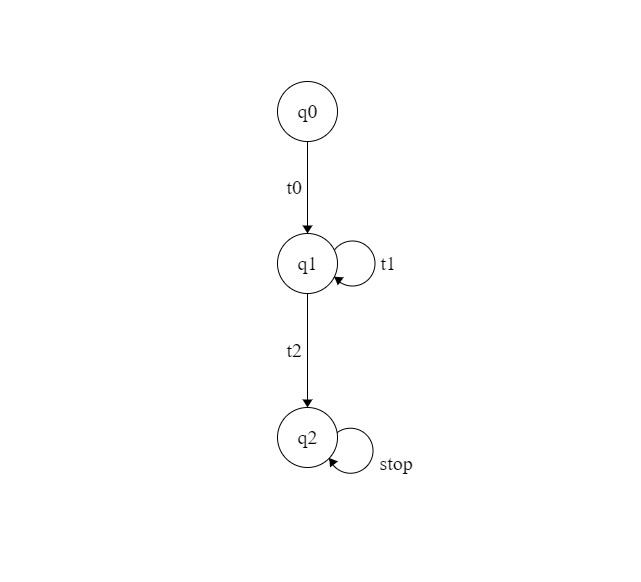

In [5]:
def trans(curr, prox, N):
    
    rules = And([
               Or(
                   And(
                       sum([curr['pos'][f'({v[0]},{v[1]})'] for v in vizinhos(i,j,N)]) == BitVecVal(3, 5),
                       curr['pos'][f'({i},{j})'] == BitVecVal(0, 5),
                       prox['pos'][f'({i},{j})'] == BitVecVal(1, 5)
                   ),
                   And(
                        Or(
                            sum([curr['pos'][f'({v[0]},{v[1]})'] for v in vizinhos(i,j,N)]) == BitVecVal(2, 5),
                            sum([curr['pos'][f'({v[0]},{v[1]})'] for v in vizinhos(i,j,N)]) == BitVecVal(3, 5)
                          ),
                       curr['pos'][f'({i},{j})'] == BitVecVal(1, 5), 
                       prox['pos'][f'({i},{j})'] == BitVecVal(1, 5)
                   ),
                   And(
                       And(
                           sum([curr['pos'][f'({v[0]},{v[1]})'] for v in vizinhos(i,j,N)]) != BitVecVal(2, 5),
                           sum([curr['pos'][f'({v[0]},{v[1]})'] for v in vizinhos(i,j,N)]) != BitVecVal(3, 5)
                       ),
                       curr['pos'][f'({i},{j})'] == BitVecVal(1, 5),
                       prox['pos'][f'({i},{j})'] == BitVecVal(0, 5)
                   ),
                   And(
                       sum([curr['pos'][f'({v[0]},{v[1]})'] for v in vizinhos(i,j,N)]) != BitVecVal(3, 5),
                       curr['pos'][f'({i},{j})'] == BitVecVal(0, 5),
                       prox['pos'][f'({i},{j})'] == BitVecVal(0, 5)
                   )
               ) 
            
                for i in range(1,N)
                for j in range(1,N)
            ])
    
    
    stay_border_x = And([ prox['pos'][f'({i},{j})'] == curr['pos'][f'({i},{j})'] for i in range(0,1) for j in range(1,N) ])
    stay_border_y = And([ prox['pos'][f'({i},{j})'] == curr['pos'][f'({i},{j})'] for i in range(1,N) for j in range(0,1) ])
    
    # t0 -> t1
    t0 = And(
        curr['pc'] == 0,
        prox['pc'] == 1,

        rules,
        
        prox['pos'][f'({0},{0})'] == curr['pos'][f'({0},{0})'],
        stay_border_x,
        stay_border_y
    )
    
    # t1 -> t1
    t1 = And(
        curr['pc'] == 1,
        prox['pc'] == 1,
        
        UGE(sum([curr['pos'][f'({i},{j})'] for i in range(1,N) for j in range(1,N)]), BitVecVal(1,5)),
        rules,
        
        prox['pos'][f'({0},{0})'] == curr['pos'][f'({0},{0})'],
        stay_border_x,
        stay_border_y
    )
    
    #t1 -> t2
    t2 = And(
        curr['pc'] == 1,
        prox['pc'] == 2,
        
        sum([curr['pos'][f'({i},{j})'] for i in range(1,N) for j in range(1,N)]) == BitVecVal(0,5),
        
        prox['pos'][f'({0},{0})'] == curr['pos'][f'({0},{0})'],
        stay_border_x,
        stay_border_y,
        
    )
    
    #t2 -> t2
    stop = And(
        curr['pc'] == 2,
        prox['pc'] == 2,
        
        And([prox['pos'][f'({i},{j})'] == curr['pos'][f'({i},{j})'] for i in range(0,N) for j in range(0,N)])
    )

    
    return Or(t0, t1, t2, stop)

#### Função gera_traco(declare, init, k, N)

    declare - Variáveis de estado
    init - Condições para o estado inicial
    k - Valor do traço
    N - Tamanho da grelha

A função `gera_traco` tem como objetivo imprimir o valor das variáveis à medida que vão percorrendo os estados, através das variáveis do estado, de um predicado que testa se um estado é inicial, um número positivo para gerar um possível traço de execução do programa de tamanho `k` e o tamanho da grelha.

In [6]:
def gera_traco(declare,init,k, prob, N):

    s = Solver()
    
    trace = [declare(i, N) for i in range(k)]

    # adicionar o estado inicial
    s.add(init(trace[0], prob, N))    
    
    # adicionar as transições
    for i in range(k - 1):
        s.add(trans(trace[i], trace[i+1], N))
    
    check = s.check()
    if check == sat:
        m = s.model()
        for i in range(k):
            for v in trace[i]:
                if v == 'pos':
                    for k in range(0, N):
                        for j in range(0, N):
                            if m[trace[i][v][f'({k},{j})']] == 0:
                                print("F", end=" ")
                            else:
                                print("T", end=" ")
                        print("\n")        
                else:
                    print(v, "=", m[trace[i][v]])
            print("----------------")
    else:
        print(check)

### Exemplo 1

#### N = 5 e ρ = 25%

In [18]:
gera_traco(declare,init,20,'25%',5)

pc = 0
F F F F T 

F F F F F 

F F T T T 

T F T T T 

F F T T T 

----------------
pc = 1
F F F F T 

F F F F T 

F T T F T 

T F F F F 

F T T F T 

----------------
pc = 1
F F F F T 

F F F F T 

F T F T F 

T F F F F 

F T F F F 

----------------
pc = 1
F F F F T 

F F F T T 

F F F F F 

T T T F F 

F F F F F 

----------------
pc = 1
F F F F T 

F F F T T 

F T T T F 

T T F F F 

F T F F F 

----------------
pc = 1
F F F F T 

F F F F T 

F T F T T 

T F F F F 

F T F F F 

----------------
pc = 1
F F F F T 

F F F F T 

F F F T T 

T T T F F 

F F F F F 

----------------
pc = 1
F F F F T 

F F F F T 

F T T T T 

T T T T F 

F T F F F 

----------------
pc = 1
F F F F T 

F F T F T 

F F F F T 

T F F F T 

F T F F F 

----------------
pc = 1
F F F F T 

F F F F T 

F F F F T 

T F F F F 

F F F F F 

----------------
pc = 1
F F F F T 

F F F T T 

F F F F F 

T F F F F 

F F F F F 

----------------
pc = 1
F F F F T 

F F F T T 

F F F F F 

T F F F F 

F F F F F 

---------

### Exemplo 2

#### N = 10 e ρ = 50%

In [19]:
gera_traco(declare,init,20,'50%',10)

pc = 0
F F T F T F F T T T 

F F F F F F F F F F 

T F F F F F F F F F 

F F F F T T T F F F 

T F F F T T T F F F 

F F F F T T T F F F 

T F F F F F F F F F 

T F F F F F F F F F 

F F F F F F F F F F 

F F F F F F F F F F 

----------------
pc = 1
F F T F T F F T T T 

F F F F F F F F T F 

T F F F F T F F F F 

F F F F T F T F F F 

T F F T F F F T F F 

F F F F T F T F F F 

T F F F F T F F F F 

T F F F F F F F F F 

F F F F F F F F F F 

F F F F F F F F F F 

----------------
pc = 1
F F T F T F F T T T 

F F F F F F F T T T 

T F F F F T F F F F 

F F F F T T T F F F 

T F F T T F T T F F 

F F F F T T T F F F 

T F F F F T F F F F 

T F F F F F F F F F 

F F F F F F F F F F 

F F F F F F F F F F 

----------------
pc = 1
F F T F T F F T T T 

F F F F F F T T F T 

T F F F T T F T T F 

F F F T F F F T F F 

T F F T F F F T F F 

F F F T F F F T F F 

T F F F T T T F F F 

T F F F F F F F F F 

F F F F F F F F F F 

F F F F F F F F F F 

----------------
pc = 1
F F T F T F F T T

### Exemplo 3

#### N = 20 e ρ = 0%

In [20]:
gera_traco(declare,init,20,'0%',20)

pc = 0
F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F T T T F F F F F 

F F F F F F F F F F F F T T T F F F F F 

F F F F F F F F F F F F T T T F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

----------------
pc = 1
F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F T T T F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F T F F F F F T F F F 

F F F F F F F F F F T F F F F F T F F F 

F F F F F F F F F F T F F F F F T F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F T T T F F F F F 

F F F F F F F F F F F F F F F F F F F F 

----------------
pc = 1
F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F F F F F F F F F F F F F F F F 

F F F F F 

### Exemplo 4

#### N = 50 e ρ = 100%

In [21]:
gera_traco(declare,init,20,'100%',50)

pc = 0
T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F

T T F F F F F F F F F T F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F T F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F F F F F F T F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F F F F F F T F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F F F F F F T F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F F F F F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T F F T F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

----------------
pc = 1
T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T 

T F F F T T T F F F F F F F F F F F F F F F F F F F F F F 

T F T F F F F F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T F F F F F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T F F F F F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T F F F F F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T F F F F F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T F F F F F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T F F F F F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T F F F F F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T F F F F F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T F F F F F F F T F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F T F T F F F F F 

T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F T F F T F F F F F 

T F F F F F F F F F F F F T T T T T T T T T T T T T T T T T T T T T T T T T F F F F T T F F F F F F 

T F F T T T F F F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F T F F F F F F F F F F F 

T F F F T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F T F F F F F F F F F F 

T F T F T F F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F T F F F F F F F F F F F 

T F F F F F F F F F F F F T T T T T T T T T T T T T T T T T T T T T T T T T F F F F F F F F F F F F 

T F F F T F F F T F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F T F F F T F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F T F F F T F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F T F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F T F F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

----------------
pc = 1
T T T T T T T T T T T T T T T T T T T T T T T T T T T T T 

T T F F F F F F F F F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F T T F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F T T F T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F T F T F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F T T T T T T T T T T T T T T T T F F F F T T F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F T T T T T T T T T T T T T T T T T F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F T T F F F F F F F F F F F F F F 

T F T T F F F F F F F F F F F F F F T T T T T T T T T T T T T T T T T F F F F F F F F F F F F F F F 

T F T T F F F F F F F F F F F F F T T T T T T T T T T T T T T T T T F F F F F F F F F F F F F F F F 

T F T T F F F F F F F F F F F F T F T T T T T T T T T T T T T T T F F F F F F F F F F F F F F F F F 

T F T T F F F F F F F T T T F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F F F F F F T T T F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F F F F F F T T T F T T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F T T F F F F F F F T T T F T T T F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

T T F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

----------------
pc = 1
T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T 

T F F F F T F F F F F F F T F F F T T T T T T T T T T T T T T T T T T T F F F F T F F F F F F F F T 

T F F F F F F F F F T T T F T F F F F F F F F F F F F F F F F F F F F F F F F F F F F T T T T F F F 

T F F F F F F F F F T T F F F T F T T T T T T T T T T T T T T T T T T T F T F F F F T F F F F F F F 

T F F F F F F F F F F F F F F F T T T T T T T T T T T T T T T T T T T T T F F F F F T T F T T F F F 

T T F F F F F F F F F F F F F F F T T T T T T T T T T T T T T T T T T T F F F F F F F T F F F F F F 

T F F F F F F F F F F F F F F F F F F F F F F F F F F F F 

### Prova das Propriedades

    1. Todos os estados acessíveis contém pelo menos uma célula viva.
    2. Toda a célula normal está viva pelo menos uma vez em algum estado acessível.

#### Propriedade 1

In [30]:
def bmc_always(declare,init,trans,prob,inv,K, N):
    for k in range(1,K+1):
        s = Solver()
            
        trace = [declare(i, N) for i in range(k)]

        # adicionar o estado inicial
        s.add(init(trace[0], prob, N))
        
        for i in range(k - 1):
            s.add(trans(trace[i], trace[i+1], N))
            
        # adicionar a negação do invariante
        s.add(Not(And([inv(trace[i], N) for i in range(k-1)])))
        
        check = s.check()
        if check == sat:
            m = s.model()
            for i in range(k):
                for v in trace[i]:
                    if v == 'pos':
                        for k in range(0, N):
                            for j in range(0, N):
                                if m[trace[i][v][f'({k},{j})']] == 0:
                                    print("F", end=" ")
                                else:
                                    print("T", end=" ")
                            print("\n")        
                    else:
                        print(v, "=", m[trace[i][v]])
                print("----------------")
            return
        else:
            print(check)
        
    print(f"O invariante mantém-se nos primeiros {K} passos")


def check_inv(state, N):
    return ( UGE(sum([ state['pos'][f'({i},{j})'] for i in range(1,N) for j in range(1,N)]), BitVecVal(1,5)) )



#### Exemplo 1 - Propriedade 1

In [32]:
bmc_always(declare,init,trans,"50%",check_inv,20, 6)

unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
O invariante mantém-se nos primeiros 20 passos


#### Exemplo 2 - Propriedade 1

#### Propriedade 2

In [33]:
bmc_always(declare,init,trans,"50%",check_inv,20, 5)

unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
pc = 0
F F F F F 

T F F F F 

F T T T F 

T T T T F 

F T T T F 

----------------
pc = 1
F F F F F 

T T T F F 

F F F T F 

T F F F T 

F F F T F 

----------------
pc = 1
F F F F F 

T T T F F 

F F T T F 

T F F T T 

F F F F F 

----------------
pc = 1
F F F F F 

T T T T F 

F F F F T 

T F T T T 

F F F F F 

----------------
pc = 1
F F F F F 

T T T T F 

F F F F T 

T F F T T 

F F F T F 

----------------
pc = 1
F F F F F 

T T T T F 

F F F F T 

T F F T T 

F F F T T 

----------------
pc = 1
F F F F F 

T T T T F 

F F F F T 

T F F F F 

F F F T T 

----------------
pc = 1
F F F F F 

T T T T F 

F F T T F 

T F F T T 

F F F F F 

----------------
pc = 1
F F F F F 

T T F T F 

F F F F F 

T F T T T 

F F F F F 

----------------
pc = 1
F F F F F 

T F F F F 

F F F F T 

T F F T F 

F F F T F 

----------------
pc = 1
F F F F F 

T F F F F 

F F F F F 

T F F T T 

F F

In [10]:
def bmc_eventually(declare,init,trans,prob,prop,K, N):
    for k in range(1,K+1):
        s = Solver()
            
        trace = [declare(i, N) for i in range(k)]

        # adicionar o estado inicial
        s.add(init(trace[0], prob, N))
        x = []
        for i in range(k - 1):
            s.add(trans(trace[i], trace[i+1], N))
        
        for j in range(1,N):
            for t in range(1,N):
                x.append(And([Not(prop(trace[l], j, t, N)) for l in range(k)]))
        
        
        s.add(Or(x))
        
        s.add(Or([trans(trace[k-1],trace[i], N) for i in range(k)]))
        
        check = s.check()
        if check == sat:
            m = s.model()
            for i in range(k):
                for v in trace[i]:
                    if v == 'pos':
                        for k in range(0, N):
                            for j in range(0, N):
                                if m[trace[i][v][f'({k},{j})']] == 0:
                                    print("F", end=" ")
                                else:
                                    print("T", end=" ")
                            print("\n")        
                    else:
                        print(v, "=", m[trace[i][v]])
                print("----------------")
            return
        else:
            print(check)
        
    print(f"O invariante mantém-se nos primeiros {K} passos")

def prop(state, i, j, N):
    return (state['pos'][f'({i},{j})'] == BitVecVal(1,5))


#### Exemplo 1 - Propriedade 2

In [8]:
bmc_eventually(declare,init,trans,"0%",prop,20, 4)

unsat
unsat
unsat
pc = 0
F F F F 

F T T T 

F T T T 

F T T T 

----------------
pc = 1
F F F F 

F T F T 

F F F F 

F T F T 

----------------
pc = 1
F F F F 

F F F F 

F F F F 

F F F F 

----------------
pc = 2
F F F F 

F T T T 

F T T T 

F T T T 

----------------


#### Exemplo 2 - Propriedade 2

In [9]:
bmc_eventually(declare,init,trans,"0%",prop,20, 6)

unsat
unsat
unsat
unsat
unsat
pc = 0
F F F F F F 

F F F F F F 

F F T T T F 

F F T T T F 

F F T T T F 

F F F F F F 

----------------
pc = 1
F F F F F F 

F F F T F F 

F F T F T F 

F T F F F T 

F F T F T F 

F F F T F F 

----------------
pc = 1
F F F F F F 

F F F T F F 

F F T T T F 

F T T F T T 

F F T T T F 

F F F T F F 

----------------
pc = 1
F F F F F F 

F F T T T F 

F T F F F T 

F T F F F T 

F T F F F T 

F F T T T F 

----------------
pc = 1
F F F F F F 

F F T T T F 

F T F T F T 

F T T F T T 

F T F T F T 

F F T T T F 

----------------
pc = 1
F F F F F F 

F F T T T F 

F T F F F T 

F T F F F T 

F T F F F T 

F F T T T F 

----------------
